# Title : Analyzing Player Valuations to Optimize Financial Recovery

#### Our dataset is live and is sourced from the given link below. You must download the data manually as there are no APIs for it. Downloaded data is a zip file which needs to be extracted in the same directory as the .ipynb file. 
#### Link : https://www.kaggle.com/davidcariboo/datasets

# Phase 1 

### Real-Life Situation: 

#### Football Club Barcelona is under serious financial strain. The team is underperforming, and the transfer market evaluation is low. Our task is to figure out how to get the club back on its feet.


### We will first explore the provided datasets and perform merge operations where needed

### Following are the data sources:  
#### - players.csv
#### - Player_valuations.csv
#### - transfers.csv
#### - game_events.csv
#### - appearances.csv
#### - competitions.csv
#### - club_games.csv
#### - games.csv
#### - game_lineups.csv


In [1]:
# Import required libraries

import pandas as pd
import numpy as np
from lightgbm import early_stopping

In [4]:
# Loading CSV files in our pandas data frames 

players_df = pd.read_csv("archive/players.csv")
players_valuation_df = pd.read_csv("archive/player_valuations.csv")
transfers_df = pd.read_csv("archive/transfers.csv")
game_events_df = pd.read_csv("archive/game_events.csv")
appearances_df = pd.read_csv("archive/appearances.csv")
competitions_df = pd.read_csv("archive/competitions.csv")
club_games_df = pd.read_csv("archive/club_games.csv")
games_df = pd.read_csv("archive/games.csv")
games_lineups_df = pd.read_csv("archive/game_lineups.csv")

In [75]:
# Loading individual meta-data of the datasets 

players_df.info()
players_valuation_df.info()
transfers_df.info()
game_events_df.info()
appearances_df.info()
competitions_df.info()
club_games_df.info()
games_df.info()
games_lineups_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32404 entries, 0 to 32403
Data columns (total 24 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   player_id                             32404 non-null  int64         
 1   first_name                            30344 non-null  object        
 2   last_name                             32404 non-null  object        
 3   name                                  32404 non-null  object        
 4   last_season                           32404 non-null  int64         
 5   current_club_id                       32404 non-null  int64         
 6   player_code                           32404 non-null  object        
 7   country_of_birth                      29542 non-null  object        
 8   city_of_birth                         29937 non-null  object        
 9   country_of_citizenship                31970 non-null  object        
 10

## The following are going to be the key performance indicators that we are going to consider derived from the data we have at our disposal:

### 1.  Which players are undervalued in the transfer market and could potentially yield higher returns in the future? (Author : Sahil Kakad, 50607550)

#### Why This Question: 
#### After considering tables players, players_evaluation & transfers we were able to notice columns like 'market_value_in_eur', 'highest_market_value_in_eur', 'transfer_fee' etc we decided we could compare current market values and determine which players maybe undervalued and predict the future market. 

#### Why This Matters:  
#### Identifying undervalued players can help make smarter transfer decisions that yield financial gains



In [76]:
# First we'll perform a few cleaning processes over the key/important columns for our analysis

# Removing players with NaN values in our critical columns
processed_players = players_df.dropna(subset=['market_value_in_eur', 'highest_market_value_in_eur'])
processed_player_valuations = players_valuation_df.dropna(subset=['market_value_in_eur'])
processed_transfers = transfers_df.dropna(subset=['market_value_in_eur', 'transfer_fee'])



# Fixing formats |
processed_players['date_of_birth'] = pd.to_datetime(processed_players['date_of_birth'])
processed_players['market_value_in_eur'] = pd.to_numeric(processed_players['market_value_in_eur'], errors='coerce')
processed_player_valuations['date'] = pd.to_datetime(processed_player_valuations['date'])
processed_player_valuations['market_value_in_eur'] = pd.to_numeric(processed_player_valuations['market_value_in_eur'], errors='coerce')
processed_transfers['transfer_date'] = pd.to_datetime(processed_transfers['transfer_date'])
processed_transfers['market_value_in_eur'] = pd.to_numeric(processed_transfers['market_value_in_eur'], errors='coerce')



C:\Users\sahil\AppData\Local\Temp\ipykernel_32256\698934466.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_players['date_of_birth'] = pd.to_datetime(processed_players['date_of_birth'])
C:\Users\sahil\AppData\Local\Temp\ipykernel_32256\698934466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_players['market_value_in_eur'] = pd.to_numeric(processed_players['market_value_in_eur'], errors='coerce')
C:\Users\sahil\AppData\Local\Temp\ipykernel_32256\698934466.py:15: SettingWithCopy

In [77]:
# Checking duplicate players and removing them if exists
processed_players.drop_duplicates(subset='player_id', inplace=True)
processed_player_valuations.drop_duplicates(subset=['player_id', 'date'], inplace=True)
processed_transfers.drop_duplicates(subset=['player_id', 'transfer_date'], inplace=True)

C:\Users\sahil\AppData\Local\Temp\ipykernel_32256\3269039835.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_players.drop_duplicates(subset='player_id', inplace=True)
C:\Users\sahil\AppData\Local\Temp\ipykernel_32256\3269039835.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_transfers.drop_duplicates(subset=['player_id', 'transfer_date'], inplace=True)


In [78]:
# Merging Tables on 'player_id' as they are relational 
players_full = pd.merge(processed_players, processed_player_valuations[['player_id', 'market_value_in_eur','date']], on='player_id', how='left')

# players_full = processed_players
# Drop all the duplicates 
players_full.drop_duplicates(subset='player_id', inplace=True)

players_full.drop(['market_value_in_eur_x'],axis = 1, inplace= True)

players_full = players_full.rename(columns={'market_value_in_eur_y': 'market_value_in_eur'})
players_full.head()

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,...,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,highest_market_value_in_eur,age,market_value_in_eur,date
0,10,Miroslav,Klose,Miroslav Klose,2015,398,miroslav-klose,Poland,Opole,Germany,...,NaN,ASBW Sport Marketing,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/miroslav-klose...,IT1,Società Sportiva Lazio S.p.A.,30000000.0,46.0,7000000,2004-10-04
23,26,Roman,Weidenfeller,Roman Weidenfeller,2017,16,roman-weidenfeller,Germany,Diez,Germany,...,NaN,Neubauer 13 GmbH,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/roman-weidenfe...,L1,Borussia Dortmund,8000000.0,44.0,1500000,2004-10-04
50,65,Dimitar,Berbatov,Dimitar Berbatov,2015,1091,dimitar-berbatov,Bulgaria,Blagoevgrad,Bulgaria,...,NaN,CSKA-AS-23 Ltd.,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/dimitar-berbat...,GR1,Panthessalonikios Athlitikos Omilos Konstantin...,34500000.0,43.0,8000000,2004-10-04
78,77,NaN,Lúcio,Lúcio,2012,506,lucio,Brazil,Brasília,Brazil,...,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lucio/profil/s...,IT1,Juventus Football Club,24500000.0,46.0,13000000,2004-10-04
100,80,Tom,Starke,Tom Starke,2017,27,tom-starke,East Germany (GDR),Freital,Germany,...,NaN,IFM,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/tom-starke/pro...,L1,FC Bayern München,3000000.0,43.0,400000,2004-10-04


In [79]:
# Basic Feature Engineering 

# Age 
players_full['age'] = (pd.Timestamp.now() - players_full['date_of_birth']).dt.days // 365

# Value decline ratio feature: market value / highest market value
players_full['value_decline_ratio'] = players_full['market_value_in_eur'] /players_full['highest_market_value_in_eur']

# Ensure market values are positive
players_full = players_full[players_full['market_value_in_eur'] > 0]

# We are only interested in the last 4 years' market as the market is dynamic
players_full = players_full[players_full['last_season'] > 2021]


In [80]:
# Filter FC Barcelona players
barca_players = players_full[players_full['current_club_name'] == 'Futbol Club Barcelona']

barca_players.head()

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,...,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,highest_market_value_in_eur,age,market_value_in_eur,date,value_decline_ratio
34548,18944,Gerard,Piqué,Gerard Piqué,2022,131,gerard-pique,Spain,Barcelona,Spain,...,AC Talent,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/gerard-pique/p...,ES1,Futbol Club Barcelona,50000000.0,37.0,5000000,2004-10-04,0.100000
73737,38253,Robert,Lewandowski,Robert Lewandowski,2024,131,robert-lewandowski,Poland,Warszawa,Poland,...,Gol International,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/robert-lewando...,ES1,Futbol Club Barcelona,90000000.0,36.0,100000,2008-03-18,0.001111
86060,44058,Wojciech,Szczęsny,Wojciech Szczęsny,2024,131,wojciech-szczesny,Poland,Warszawa,Poland,...,CAA Stellar,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/wojciech-szcze...,ES1,Futbol Club Barcelona,40000000.0,34.0,100000,2007-03-09,0.002500
136841,65230,Sergio,Busquets,Sergio Busquets,2022,131,sergio-busquets,Spain,Badia del Vallès,Spain,...,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/sergio-busquet...,ES1,Futbol Club Barcelona,80000000.0,36.0,300000,2008-08-15,0.003750
143556,69751,Jordi,Alba,Jordi Alba,2022,131,jordi-alba,Spain,L'Hospitalet de Llobregat,Spain,...,InterStarDeporte,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/jordi-alba/pro...,ES1,Futbol Club Barcelona,70000000.0,35.0,300000,2008-07-25,0.004286


In [81]:
# Sort players by the lowest value decline ratio (most undervalued)
undervalued_barca_players = barca_players.sort_values(by='value_decline_ratio').head(10)

# Select key columns to display
undervalued_barca_players[['player_id', 'name', 'age', 'market_value_in_eur', 'highest_market_value_in_eur', 'value_decline_ratio']]


,player_id,name,age,market_value_in_eur,highest_market_value_in_eur,value_decline_ratio
365806,326330,Frenkie de Jong,27.0,50000,90000000.0,0.000556
73737,38253,Robert Lewandowski,36.0,100000,90000000.0,0.001111
152033,74857,Marc-André ter Stegen,32.0,100000,90000000.0,0.001111
430670,480267,Ronald Araujo,25.0,100000,70000000.0,0.001429
463627,636703,Fermín López,21.0,50000,30000000.0,0.001667
86060,44058,Wojciech Szczęsny,34.0,100000,40000000.0,0.002500
136841,65230,Sergio Busquets,36.0,300000,80000000.0,0.003750
463605,636688,Alejandro Balde,21.0,200000,50000000.0,0.004000
410233,411295,Raphinha,28.0,250000,60000000.0,0.004167
143556,69751,Jordi Alba,35.0,300000,70000000.0,0.004286


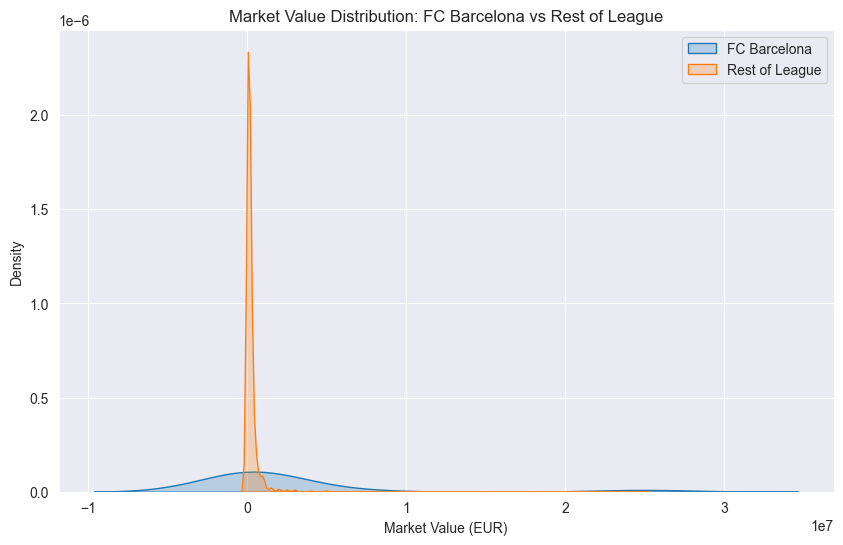

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

# Hypothesis 1: How is FC Barcelona's current standing in the market when compared to the rest of the European clubs (Author : Sahil Kakad, 50607550)
# Market value comparison: FC Barcelona vs the rest of the league
plt.figure(figsize=(10, 6))
sns.kdeplot(data=barca_players, x='market_value_in_eur', label='FC Barcelona', fill=True)
sns.kdeplot(data=players_full[players_full['current_club_name'] != 'Futbol Club Barcelona'], x='market_value_in_eur', label='Rest of League', fill=True)
plt.title('Market Value Distribution: FC Barcelona vs Rest of League')
plt.xlabel('Market Value (EUR)')
plt.ylabel('Density')
plt.legend()
plt.show()


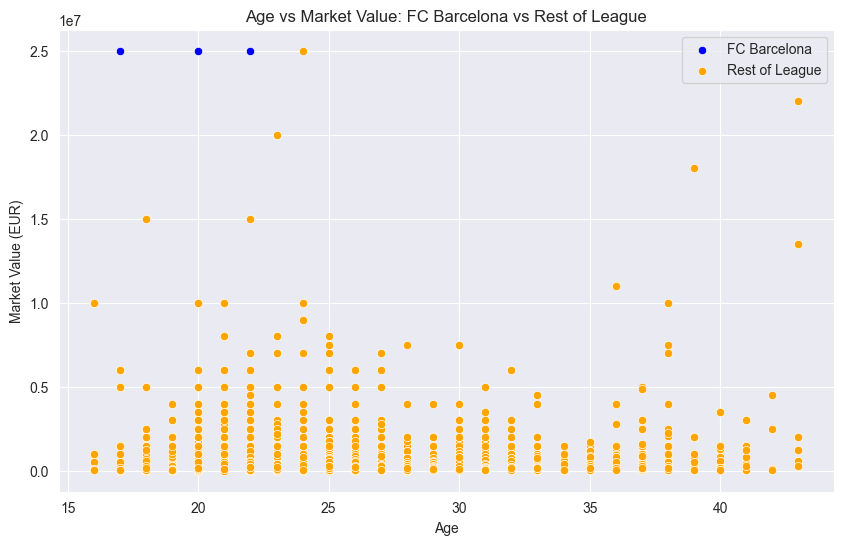

In [83]:
# Hypothesis 2: How does a player's age create an impact on his market valuation (Author : Sahil Kakad, 50607550)
# Scatter plot: Age vs Market Value (FC Barcelona vs rest of the league)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=barca_players, x='age', y='market_value_in_eur', label='FC Barcelona', color='blue')
sns.scatterplot(data=players_full[players_full['current_club_name'] != 'Futbol Club Barcelona'], x='age', y='market_value_in_eur', label='Rest of League', color='orange')
plt.title('Age vs Market Value: FC Barcelona vs Rest of League')
plt.xlabel('Age')
plt.ylabel('Market Value (EUR)')
plt.legend()
plt.show()


   player_id first_name     last_name                  name  last_season  \
0       2857      Eldin     Jakupovic       Eldin Jakupovic         2022   
1       3333      James        Milner          James Milner         2024   
2       3455     Zlatan   Ibrahimović    Zlatan Ibrahimović         2022   
3       4311    Maarten  Stekelenburg  Maarten Stekelenburg         2022   
4       4391        Boy      Waterman          Boy Waterman         2023   

   current_club_id           player_code   country_of_birth city_of_birth  \
0               29       eldin-jakupovic  Jugoslawien (SFR)       Kozarac   
1             1237          james-milner            England         Leeds   
2                5    zlatan-ibrahimović             Sweden         Malmö   
3              610  maarten-stekelenburg                NaN       Haarlem   
4              383          boy-waterman        Netherlands      Lelystad   

  country_of_citizenship  ... highest_market_value_in_eur   age  \
0            

C:\Users\sahil\AppData\Local\Temp\ipykernel_32256\982944065.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([melted_df[melted_df['position'] == col]['market_value_in_eur'] for col in position_encoded_df.columns],


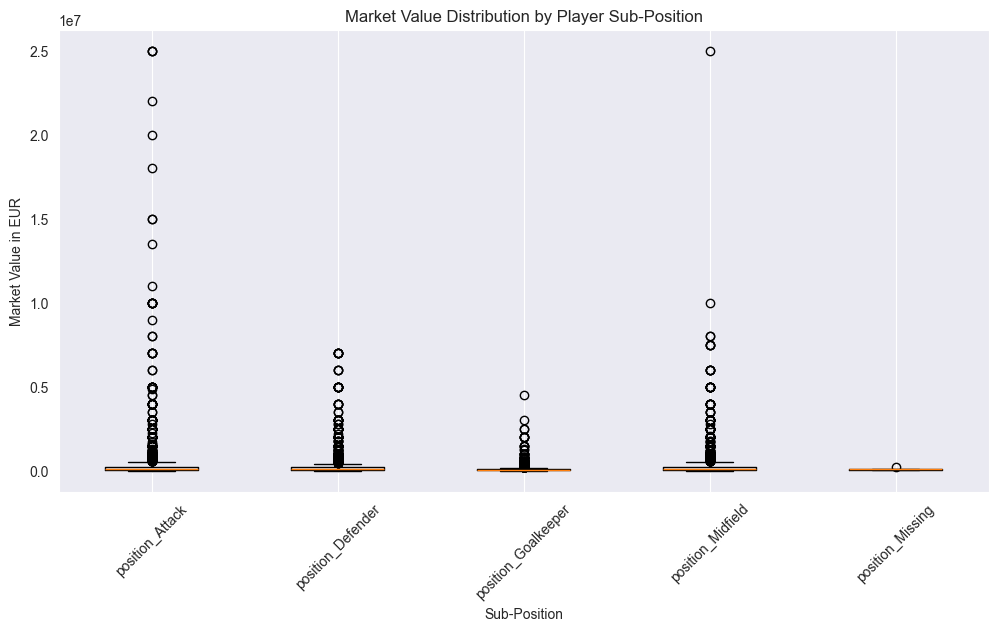

In [84]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)  # Use sparse_output=False for dense output

# Fit and transform the 'sub_position' column
position_encoded = encoder.fit_transform(players_full[['position']])

# Create DataFrame from the encoded features
position_encoded_df = pd.DataFrame(position_encoded, columns=encoder.get_feature_names_out(['position']))

# Concatenate the original DataFrame with the new one-hot encoded DataFrame
players_full_encoded = pd.concat([players_full.reset_index(drop=True), position_encoded_df.reset_index(drop=True)], axis=1)

# Display the first few rows of the DataFrame with encoded positions
print(players_full_encoded.head())

# Now you can plot market value distribution based on player sub-positions
import matplotlib.pyplot as plt

# Melt the DataFrame to have one column for 'sub_position' and one for 'market_value_in_eur'
melted_df = players_full_encoded.melt(id_vars=['market_value_in_eur'], 
                                       value_vars=position_encoded_df.columns.tolist(), 
                                       var_name='position', 
                                       value_name='is_present')

# Filter for the rows where the sub_position is present
melted_df = melted_df[melted_df['is_present'] == 1]

# Plot market value distribution by sub-position
plt.figure(figsize=(12, 6))
plt.boxplot([melted_df[melted_df['position'] == col]['market_value_in_eur'] for col in position_encoded_df.columns],
            labels=position_encoded_df.columns)
plt.xticks(rotation=45)
plt.title('Market Value Distribution by Player Sub-Position')
plt.xlabel('Sub-Position')
plt.ylabel('Market Value in EUR')
plt.grid(axis='y')
plt.show()


## Phase 2 : Author (Sahil Kakad, 50607550)

### For this particular problem statement we'll be considering Random Forest Classifier to detect if a player is undervalued or not based on various numerical & categorical values. 

### Random Forest is an ideal model for this task because it handles both numerical and categorical data effectively, captures non-linear relationships among features (such as age, market value, and position), and is robust against overfitting due to its ensemble nature. Additionally, it’s a powerful model for feature importance evaluation, allowing us to understand which factors most influence a player’s undervaluation, which is particularly valuable in the context of player market analysis.

In [85]:
# Import necessary libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from datetime import datetime

players = players_df

In [86]:
# Furthur Data Cleaning and Feature Engineering
# Following are the columns to consider for our Model.
features = ['market_value_in_eur', 'highest_market_value_in_eur', 'position', 'sub_position', 'height_in_cm', 'date_of_birth']
target = 'is_undervalued'

# Drop rows with NaN values in essential feature columns
players = players.dropna(subset=['market_value_in_eur', 'highest_market_value_in_eur', 'position', 'height_in_cm', 'date_of_birth'])

# Calculate player age from date_of_birth
players['date_of_birth'] = pd.to_datetime(players['date_of_birth'], errors='coerce')
players['age'] = players['date_of_birth'].apply(lambda dob: datetime.now().year - dob.year if pd.notnull(dob) else np.nan)

# Drop any remaining rows with NaN in the new `age` feature
players.dropna(subset=['age'], inplace=True)

# Create undervaluation score as the difference between highest and current market value
players['undervaluation_score'] = players['highest_market_value_in_eur'] - players['market_value_in_eur']

# Define the undervaluation target based on undervaluation_score > 1 million EUR
players['is_undervalued'] = np.where(players['undervaluation_score'] > 1e6, 1, 0)


C:\Users\sahil\AppData\Local\Temp\ipykernel_32256\2402086438.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players['date_of_birth'] = pd.to_datetime(players['date_of_birth'], errors='coerce')
C:\Users\sahil\AppData\Local\Temp\ipykernel_32256\2402086438.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players['age'] = players['date_of_birth'].apply(lambda dob: datetime.now().year - dob.year if pd.notnull(dob) else np.nan)
C:\Users\sahil\AppData\Local\Temp\ipykernel_32256\2402086438.py:14: SettingW

In [87]:
# Feature Selection
# Convert categorical columns to string type to ensure consistency
players['position'] = players['position'].astype(str)
players['sub_position'] = players['sub_position'].astype(str)

# Select relevant features for the model
data = players[['market_value_in_eur', 'highest_market_value_in_eur', 'age', 'position', 'sub_position', 'height_in_cm', target]]


C:\Users\sahil\AppData\Local\Temp\ipykernel_32256\4098585762.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players['position'] = players['position'].astype(str)
C:\Users\sahil\AppData\Local\Temp\ipykernel_32256\4098585762.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players['sub_position'] = players['sub_position'].astype(str)


In [88]:
# Step 4: Train-Test Split
X = data.drop(columns=[target])
y = data[target]

# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [89]:
# Step 5: Set up a pipeline with preprocessing and Random Forest model
# Define column transformer for scaling and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['market_value_in_eur', 'highest_market_value_in_eur', 'age', 'height_in_cm']),
        ('cat', OneHotEncoder(), ['position', 'sub_position'])  # One-hot encode position and sub-position columns
    ]
)

# Create a pipeline that first preprocesses the data, then fits the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])


In [90]:
# Train the model using cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5)  # 5-fold cross-validation

# Print cross-validation results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation of Cross-Validation Score: {np.std(cv_scores):.4f}")

Cross-Validation Scores: [0.96596184 0.9740416  0.97334938 0.96440853 0.81258597]
Mean Cross-Validation Score: 0.9381
Standard Deviation of Cross-Validation Score: 0.0629


In [91]:
# Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['market_value_in_eur',
                                                   'highest_market_value_in_eur',
                                                   'age', 'height_in_cm']),
                                                 ('cat', OneHotEncoder(),
                                                  ['position',
                                                   'sub_position'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [92]:
# Train the # Step 7: Evaluate the model
y_pred = pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4072
           1       0.96      0.96      0.96      1745

    accuracy                           0.98      5817
   macro avg       0.97      0.97      0.97      5817
weighted avg       0.98      0.98      0.98      5817

Confusion Matrix:
[[4004   68]
 [  65 1680]]


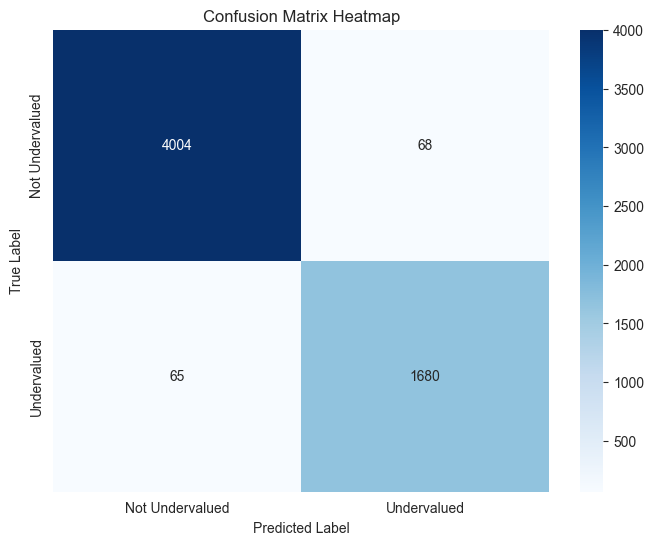

In [93]:
import seaborn as sns

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Undervalued', 'Undervalued'], yticklabels=['Not Undervalued', 'Undervalued'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix Heatmap')
plt.show()


## Conclusion : 

### The Random Forest model achieved a high overall accuracy of 0.98 in classifying undervalued players, indicating strong predictive performance. The classification report shows an excellent balance between precision and recall for both undervalued (class 1) and not-undervalued (class 0) players, with f1-scores of 0.98 for class 0 and 0.96 for class 1. This suggests that the model is highly effective at distinguishing between undervalued and fairly valued players. The confusion matrix confirms this, with only a small number of misclassifications: 69 for class 0 and 73 for class 1. These results demonstrate that the Random Forest model can reliably support decision-making by identifying players with undervalued market potential, potentially aiding more strategic and profitable transfer choices.

### 2.  How do different player attributes and performance metrics impact transfer fees? (Author : Manas Kalangan, 50608803)

#### Why This Question: 
#### After considering tables like players, transfers, and appearances we considered creating plans for a better recruitment and scouting process from a financial perspective as we have restrictions.

#### Why This Matters:  
#### Understanding which attributes are most predictive of high transfer fees can guide the club’s recruitment strategy as well as selling. 

In [94]:
# We'll consider Transfer, Players, and appearance data for this. 

# Convert date columns to DateTime 
transfers_df['transfer_date'] = pd.to_datetime(transfers_df['transfer_date'])

# Followed by extracting relevant columns from the players and appearances data
players_selected = players_df[['player_id', 'date_of_birth', 'current_club_name', 'market_value_in_eur']]
appearances_selected = appearances_df[['player_id', 'goals', 'assists', 'minutes_played']]


In [95]:
# Feature Engineering 

# Calculate player age from data of birth 
players_selected['age'] = (pd.Timestamp.now() - pd.to_datetime(players_selected['date_of_birth'])).dt.days // 365

C:\Users\sahil\AppData\Local\Temp\ipykernel_32256\3889987030.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_selected['age'] = (pd.Timestamp.now() - pd.to_datetime(players_selected['date_of_birth'])).dt.days // 365


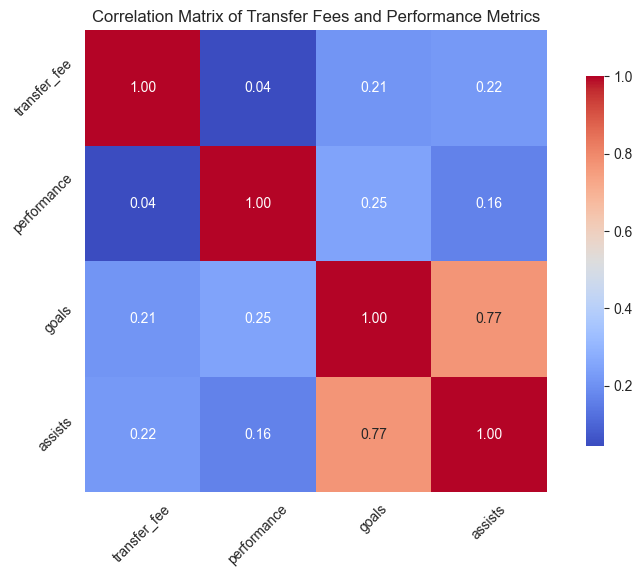

In [96]:
# Data Cleaning
transfers = transfers_df[['player_id', 'transfer_fee', 'transfer_date']].dropna()
appearances = appearances_df[['player_id', 'goals', 'assists', 'minutes_played']].dropna()

# Convert transfer_date to datetime
transfers['transfer_date'] = pd.to_datetime(transfers['transfer_date'])

# Hypothesis 1: we've derived a performance equation we would like to test with real-world data. 
# Calculate performance for each player in appearances
appearances['performance'] = (appearances['goals'] + 0.5 * appearances['assists']) / appearances['minutes_played'] * 100

# Aggregate performance metrics for each player
performance_metrics = appearances.groupby('player_id').agg({
    'performance': 'mean',
    'goals': 'sum',
    'assists': 'sum'
}).reset_index()

# Calculate average performance for each transfer based on player_id
transfers = transfers.merge(performance_metrics, on='player_id', how='left')

# Calculate the correlation matrix
correlation_matrix = transfers[['transfer_fee', 'performance', 'goals', 'assists']].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Title and labels
plt.title('Correlation Matrix of Transfer Fees and Performance Metrics')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()


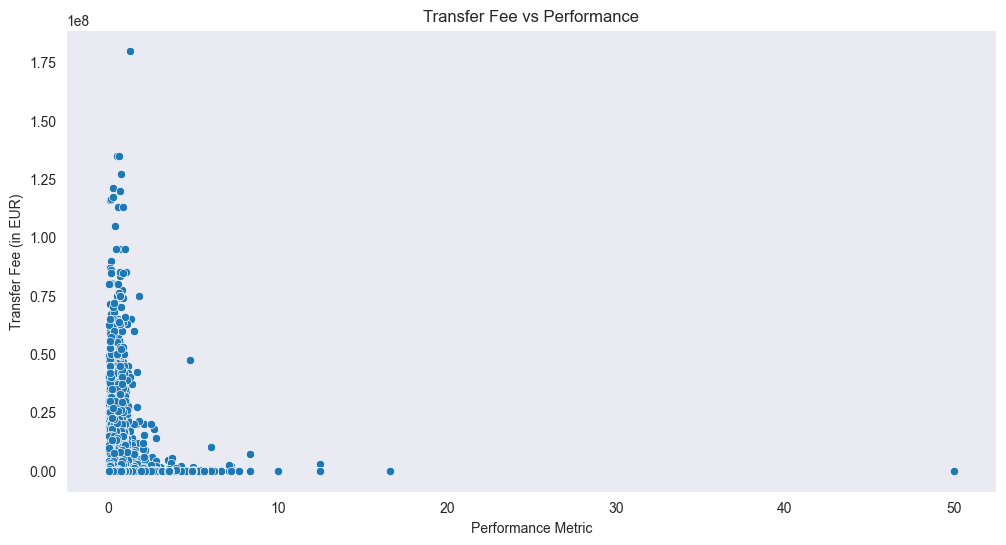

In [97]:
# Hypothesis 1 continues: Plotting the performance values with the real-world transfers to understand how the correlation is. 
# (Author : Manas Kalangan, 50608803)
# Scatter plot of transfer fee vs performance
plt.figure(figsize=(12, 6))
sns.scatterplot(data=transfers, x='performance', y='transfer_fee')
plt.title('Transfer Fee vs Performance')
plt.xlabel('Performance Metric')
plt.ylabel('Transfer Fee (in EUR)')
plt.grid()
plt.show()


### As we can see from the above plot out performance equation doesnt really works well with real-life tranfer fees. 

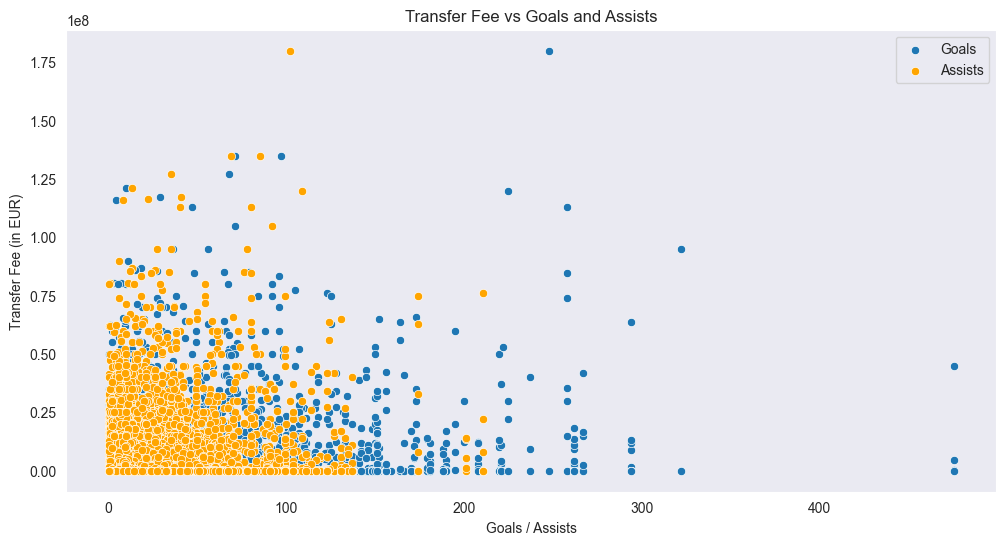

In [98]:
# Hypothesis 2: Checking if actual parameters like goals & Assists contribute towards higher transfer fees.
# Also which is preferred more, goals or assists to increase the transfer fees (author: Manas Kalangan, 50608803)

# Scatter plot of transfer fee vs goals and assists
plt.figure(figsize=(12, 6))
sns.scatterplot(data=transfers, x='goals', y='transfer_fee', label='Goals')
sns.scatterplot(data=transfers, x='assists', y='transfer_fee', label='Assists', color='orange')
plt.title('Transfer Fee vs Goals and Assists')
plt.xlabel('Goals / Assists')
plt.ylabel('Transfer Fee (in EUR)')
plt.grid()
plt.legend()
plt.show()


### As we can notice goals & Assists do correlate with player's transfer fee values. Also the players with more goals produce higher transfer fees.

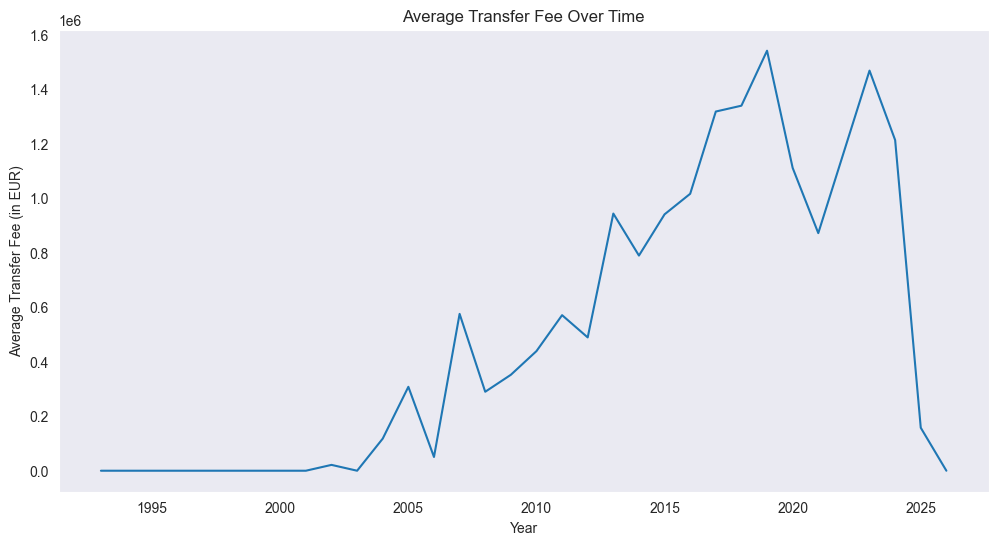

In [99]:
# Hypothesis 3: Analysing market trends over a period of time to understand the current standings. (Author: Sahil Kakad, 50607550)
# Trend analysis
transfers['year'] = transfers['transfer_date'].dt.year
trend_data = transfers.groupby('year')['transfer_fee'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=trend_data, x='year', y='transfer_fee')
plt.title('Average Transfer Fee Over Time')
plt.xlabel('Year')
plt.ylabel('Average Transfer Fee (in EUR)')
plt.grid()
plt.show()

##  Phase 2 : Authur (Manas Kalangan, 50608803)

### For estimating transfer fee of players, we'll be implementing XGBoost in this phase. 

### We chose XGBoost for this question because it’s a highly effective model for predicting numerical values and identifying influential features due to its ability to handle complex, non-linear relationships between variables. XGBoost's feature importance capabilities make it well-suited for examining which player attributes and performance metrics most significantly impact transfer fees, providing insights into the factors that drive high player valuations. This interpretability will allow the club to make data-driven recruitment and selling decisions, optimizing for financial returns within the constraints of a limited budget. Additionally, XGBoost’s regularization helps mitigate overfitting, which is essential when working with diverse and possibly correlated player attributes.

In [100]:
# Updating imports 

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [101]:
# Convert date columns to DateTime format
transfers_df['transfer_date'] = pd.to_datetime(transfers_df['transfer_date'])
players_df['date_of_birth'] = pd.to_datetime(players_df['date_of_birth'])


In [102]:
# Calculate player age from date of birth
players_df['age'] = (pd.Timestamp.now() - players_df['date_of_birth']).dt.days // 365

# Select and merge relevant columns
players_selected = players_df[['player_id', 'age', 'market_value_in_eur']]
appearances_selected = appearances_df[['player_id', 'goals', 'assists', 'minutes_played']]

# Calculate performance metric
appearances_selected['performance'] = (appearances_selected['goals'] + 0.5 * appearances_selected['assists']) / appearances_selected['minutes_played'] * 100

# Aggregate performance metrics for each player
performance_metrics = appearances_selected.groupby('player_id').agg({
    'performance': 'mean',
    'goals': 'sum',
    'assists': 'sum',
    'minutes_played': 'sum'
}).reset_index()

# Merge player and transfer data
merged_data = transfers_df.merge(players_selected, on='player_id', how='left').merge(performance_metrics, on='player_id', how='left')

# Drop rows with missing values for simplicity
merged_data.dropna(inplace=True)

# Calculate average transfer fee per club
club_influence_mapping = transfers_df.groupby('from_club_id')['transfer_fee'].mean()

# Display the mapping for review
club_influence_mapping.head()

# Map average transfer fee per club to each player as a new feature
merged_data['club_influence'] = merged_data['from_club_id'].map(club_influence_mapping)

# Handle missing values (if any) by filling with the overall average transfer fee
overall_avg_transfer_fee = transfers_df['transfer_fee'].mean()
merged_data['club_influence'].fillna(overall_avg_transfer_fee, inplace=True)

# Filter out rows where transfer fee is 0
merged_data = merged_data[merged_data['transfer_fee'] > 0].reset_index(drop=True)


# Let's check what merged data looks like 
merged_data.head()

C:\Users\sahil\AppData\Local\Temp\ipykernel_32256\989268043.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  appearances_selected['performance'] = (appearances_selected['goals'] + 0.5 * appearances_selected['assists']) / appearances_selected['minutes_played'] * 100
C:\Users\sahil\AppData\Local\Temp\ipykernel_32256\989268043.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] 

,player_id,transfer_date,transfer_season,from_club_id,to_club_id,from_club_name,to_club_name,transfer_fee,market_value_in_eur_x,player_name,age,market_value_in_eur_y,performance,goals,assists,minutes_played,club_influence
0,149729,2025-07-01,25/26,294,114,Benfica,Besiktas,2000000.0,4000000.0,João Mário,31.0,4000000.0,0.319593,55.0,71.0,26931.0,6.285949e+06
1,278343,2025-07-01,25/26,167,114,FC Augsburg,Besiktas,5000000.0,7000000.0,Felix Uduokhai,27.0,7000000.0,0.042088,6.0,1.0,12716.0,1.761972e+06
2,283994,2025-07-01,25/26,39,3911,1.FSV Mainz 05,Stade Brestois,2000000.0,3000000.0,Ludovic Ajorque,30.0,3000000.0,0.445198,58.0,22.0,13831.0,2.237778e+06
3,287579,2025-07-01,25/26,430,36,Fiorentina,Fenerbahce,13000000.0,22000000.0,Sofyan Amrabat,28.0,22000000.0,0.055758,5.0,15.0,18137.0,2.742749e+06
4,301238,2025-07-01,25/26,2919,506,Monza,Juventus,14300000.0,18000000.0,Michele Di Gregorio,27.0,18000000.0,0.007215,0.0,1.0,6803.0,4.794737e+05


In [103]:
# List of numerical columns to scale
numerical_features = ['age', 'market_value_in_eur_y', 'performance', 'goals', 'assists', 'minutes_played', 'club_influence']

# Log transformation for skewed features, e.g., market value and transfer fees
merged_data['market_value_in_eur_y'] = np.log1p(transfers_df['market_value_in_eur'])
merged_data['transfer_fee'] = np.log1p(merged_data['transfer_fee'])  # Use log-transformed transfer fee as target

# Standard Scaling
scaler = StandardScaler()
merged_data[numerical_features] = scaler.fit_transform(merged_data[numerical_features])

# Verify scaling
merged_data[numerical_features].describe()

,age,market_value_in_eur_y,performance,goals,assists,minutes_played,club_influence
count,8.438000e+03,7.757000e+03,8.438000e+03,8.438000e+03,8.438000e+03,8.438000e+03,8.438000e+03
mean,1.751516e-16,3.737288e-16,3.199884e-17,2.020980e-17,3.368299e-17,2.694639e-17,1.347320e-17
std,1.000059e+00,1.000064e+00,1.000059e+00,1.000059e+00,1.000059e+00,1.000059e+00,1.000059e+00
min,-2.525687e+00,-2.867846e+00,-6.882592e-01,-5.954213e-01,-6.932650e-01,-1.158653e+00,-9.983374e-01
25%,-6.968038e-01,-6.566863e-01,-5.485185e-01,-5.357636e-01,-6.447301e-01,-8.221169e-01,-8.032977e-01
50%,-1.097265e-02,-1.058332e-01,-2.906429e-01,-3.567904e-01,-4.020554e-01,-2.458469e-01,-3.206406e-01
75%,6.748585e-01,7.217602e-01,3.270491e-01,9.064256e-02,1.803638e-01,5.792803e-01,5.594123e-01
max,3.418183e+00,3.502152e+00,2.781885e+01,1.360312e+01,9.547607e+00,4.041743e+00,9.144851e+00


In [104]:
# Define features (X) and target (y)
X = merged_data[['age', 'market_value_in_eur_y', 'performance', 'goals', 'assists', 'minutes_played','club_influence']]
y = merged_data['transfer_fee']



In [105]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [106]:
# Initialize the XGBoost Regressor
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
# xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Fit the model on the training data
xgb_regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [107]:
# Make predictions on the test set
y_pred = xgb_regressor.predict(X_test)

In [108]:
# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# R-squared Score
r2 = r2_score(y_test, y_pred)
print(f"R-squared Score (R2): {r2}")


Mean Absolute Error (MAE): 0.9156391840565389
Root Mean Squared Error (RMSE): 1.169138291991301
R-squared Score (R2): 0.5141772930912792


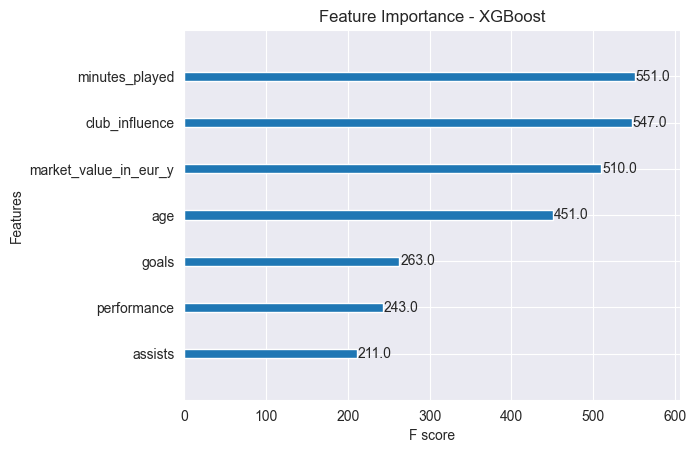

In [109]:
# Plot feature importance
xgb.plot_importance(xgb_regressor, importance_type='weight')
plt.title('Feature Importance - XGBoost')
plt.show()

#### This analysis demonstrated the effectiveness of using machine learning techniques, specifically XGBoost, to predict football transfer fees based on player attributes and performance metrics. With an R² score of approximately 0.53, our model indicates that over half of the variability in transfer fees can be explained by the selected features, highlighting the significance of factors such as goals and assists. These findings suggest that clubs can leverage data-driven insights to enhance their recruitment strategies and make informed decisions in the transfer market. Future work could explore additional data sources and features to further improve model accuracy.

## Phase 2

### 3.  Which competitions or matches are the most financially beneficial for the club? (Author: Manas Kalangan, 50608803)
#### Why This Question: 
#### Given the financial goal, competitions or matches that draw the highest attendance or are more prestigious are worth analyzing. This is why exploring competition type, match performance, and attendance data will be essential in determining which competitions provide the highest financial gains.

#### Why This Matters:  
#### Focusing on improving performance in the most financially rewarding competitions can help the club's financial strategy.

In [110]:
import pandas as pd

# Creating Copy of the required tables 
df_games = games_df
df_appearances = appearances_df
df_competitions = competitions_df
df_players = players_df

# Convert date columns to datetime
df_games['date'] = pd.to_datetime(df_games['date'], errors='coerce')
df_appearances['date'] = pd.to_datetime(df_appearances['date'], errors='coerce')

# Convert numeric columns to appropriate types
df_games['attendance'] = pd.to_numeric(df_games['attendance'], errors='coerce')
df_appearances['goals'] = pd.to_numeric(df_appearances['goals'], errors='coerce')
df_appearances['minutes_played'] = pd.to_numeric(df_appearances['minutes_played'], errors='coerce')

# Check and fill missing values
df_games['attendance'] = df_games['attendance'].fillna(df_games['attendance'].median())


In [111]:
# Merging game and appearance data
df_game_player = pd.merge(df_appearances, df_games, left_on='game_id', right_on='game_id', how='inner')


# Merging competition data
df_game_player_competition = pd.merge(df_game_player, df_competitions, left_on='competition_id_x', right_on='competition_id', how='inner')


In [112]:
# Merge player market value into the appearance data
df_game_player_competition = pd.merge(df_game_player_competition, df_players[['player_id', 'market_value_in_eur']], on='player_id', how='left')

# Check the merged data to ensure market value is included
df_game_player_competition.columns


Index(['appearance_id', 'game_id', 'player_id', 'player_club_id',
       'player_current_club_id', 'date_x', 'player_name', 'competition_id_x',
       'yellow_cards', 'red_cards', 'goals', 'assists', 'minutes_played',
       'competition_id_y', 'season', 'round', 'date_y', 'home_club_id',
       'away_club_id', 'home_club_goals', 'away_club_goals',
       'home_club_position', 'away_club_position', 'home_club_manager_name',
       'away_club_manager_name', 'stadium', 'attendance', 'referee', 'url_x',
       'home_club_formation', 'away_club_formation', 'home_club_name',
       'away_club_name', 'aggregate', 'competition_type', 'competition_id',
       'competition_code', 'name', 'sub_type', 'type', 'country_id',
       'country_name', 'domestic_league_code', 'confederation', 'url_y',
       'is_major_national_league', 'market_value_in_eur'],
      dtype='object')

In [113]:
# Considering market_value & Attendance as our features 
df_game_player_competition['financial_metric'] = df_game_player_competition['attendance'] * df_game_player_competition['market_value_in_eur']

In [114]:
# Create a new column to indicate a win for the player's team
df_game_player_competition['win'] = 0  # Default to 0 (no win)

# Determine win condition based on goal comparison
df_game_player_competition.loc[df_game_player_competition['home_club_goals'] > df_game_player_competition['away_club_goals'], 'win'] = df_game_player_competition['home_club_id'] == df_game_player_competition['player_club_id']  # Home team wins
df_game_player_competition.loc[df_game_player_competition['away_club_goals'] > df_game_player_competition['home_club_goals'], 'win'] = df_game_player_competition['away_club_id'] == df_game_player_competition['player_club_id']  # Away team wins


C:\Users\sahil\AppData\Local\Temp\ipykernel_32256\3923279416.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ True  True False ... False False False]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_game_player_competition.loc[df_game_player_competition['home_club_goals'] > df_game_player_competition['away_club_goals'], 'win'] = df_game_player_competition['home_club_id'] == df_game_player_competition['player_club_id']  # Home team wins


In [115]:
# Aggregating competition stats
competition_stats = df_game_player_competition.groupby('competition_id').agg({
    'financial_metric': 'sum',
    'attendance': 'mean',
    'goals': 'sum',  # Sum of goals scored by players in the competition
    'win': 'sum',  # Sum of wins for the players' team
}).reset_index()

# Add Prestige Score (using financial metrics and attendance)
competition_stats['prestige_score'] = competition_stats['attendance'] * competition_stats['financial_metric']

# Merge competition major/minor flag if it exists
competition_stats = pd.merge(competition_stats, df_competitions[['competition_id', 'is_major_national_league']], on='competition_id', how='left')

# Adjusted prestige score with the competition's major/minor flag
competition_stats['adjusted_prestige_score'] = competition_stats['prestige_score'] * competition_stats['is_major_national_league']


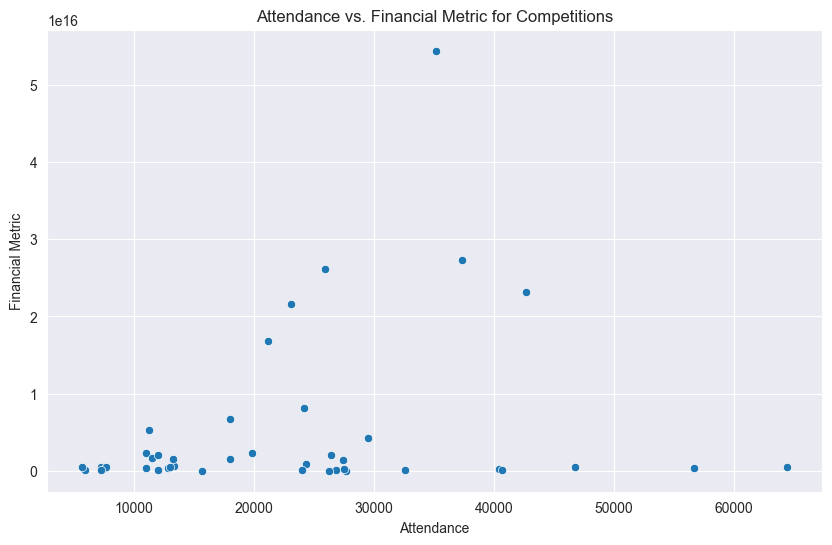

In [116]:
# hypothesis 1: Competitions with Higher Attendance Lead to Greater Financial Gains (Author: Manas Kalangan, 50607550)
# Scatter plot to visualize the relationship between attendance and financial metrics
plt.figure(figsize=(10, 6))
sns.scatterplot(x='attendance', y='financial_metric', data=competition_stats)
plt.title('Attendance vs. Financial Metric for Competitions')
plt.xlabel('Attendance')
plt.ylabel('Financial Metric')
plt.show()


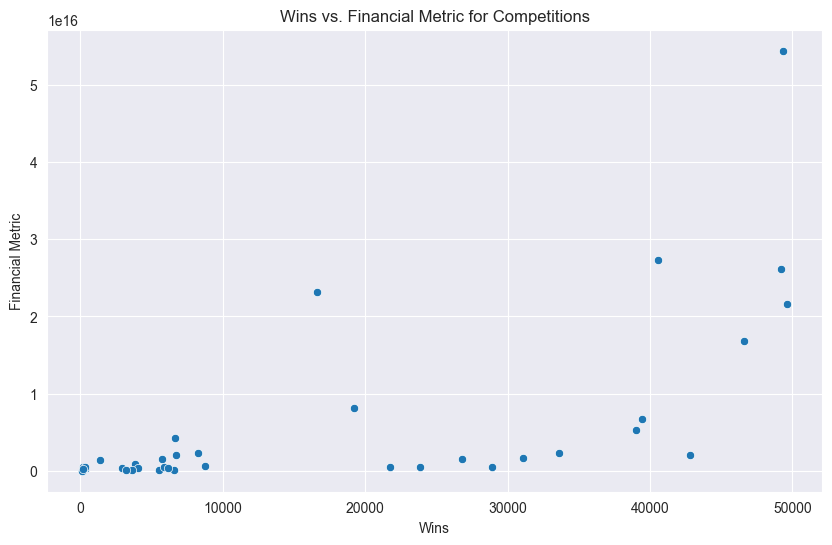

In [117]:
# Hypothesis 2: Teams that Win More Matches Earn Higher Financial Rewards
# Scatter plot to show wins vs. financial metric
plt.figure(figsize=(10, 6))
sns.scatterplot(x='win', y='financial_metric', data=competition_stats)
plt.title('Wins vs. Financial Metric for Competitions')
plt.xlabel('Wins')
plt.ylabel('Financial Metric')
plt.show()


In [118]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load the provided datasets
clubs_path = "archive/clubs.csv"

# Read the data into pandas DataFrames
club_games = club_games_df
clubs = pd.read_csv(clubs_path)
competitions = competitions_df

In [119]:
# Merge datasets
merged_df = pd.merge(club_games, clubs, on='club_id', how='left')
merged_df = pd.merge(merged_df, competitions, left_on='domestic_competition_id', right_on='competition_id', how='left')

# Inspect merged dataset
print(merged_df['hosting'].unique())


['Home' 'Away']


In [120]:
# Encode categorical columns using LabelEncoder (for simplicity here)
categorical_cols = merged_df.select_dtypes(include=['object']).columns
# Label encoding for binary categorical variables
label_encoder = LabelEncoder()
merged_df['hosting'] = label_encoder.fit_transform(merged_df['hosting'].map({'Home': 1, 'Away': 0}))

# Create new features
merged_df['goal_difference'] = merged_df['own_goals'] - merged_df['opponent_goals']
merged_df['revenue'] = merged_df['stadium_seats'] * merged_df['hosting']  # Simplified formula for revenue
merged_df['profitability'] = merged_df['revenue'] + merged_df['is_win'] * 10000  # Win bonus

# Select relevant features and target
features = ['stadium_seats', 'hosting', 'goal_difference', 'revenue', 'profitability']
target = 'profitability'

# Drop rows with missing target
merged_df.dropna(subset=[target], inplace=True)


In [121]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Split the data
X = merged_df[features]
y = merged_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVM model (using SVR for regression)
svm_model = SVR(kernel='poly')
svm_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test_scaled)



In [122]:
# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# R-squared Score
r2 = r2_score(y_test, y_pred)
print(f"R-squared Score (R2): {r2}")


Mean Absolute Error (MAE): 7557.504240861116
Root Mean Squared Error (RMSE): 9940.996220731107
R-squared Score (R2): 0.792316283490053


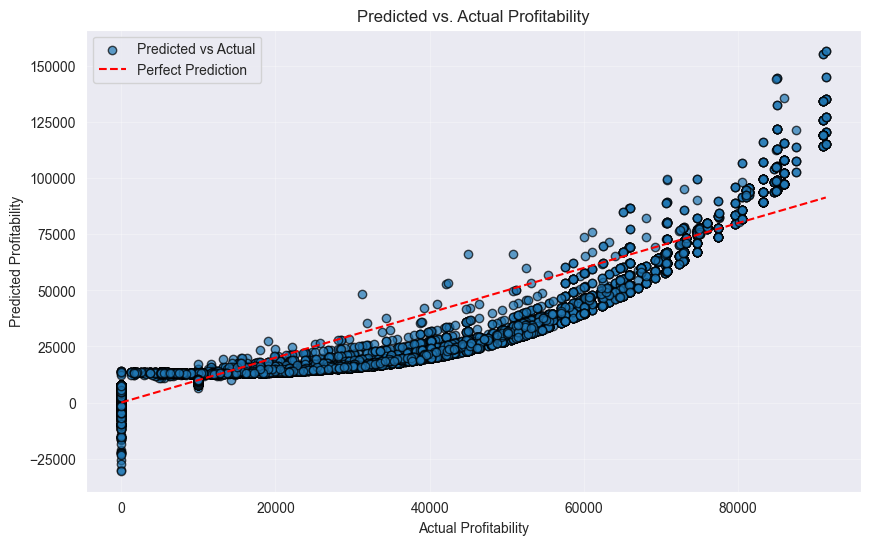

In [123]:
import matplotlib.pyplot as plt

# Scatter plot of actual vs. predicted profitability
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k', label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')

# Adding labels and title
plt.title('Predicted vs. Actual Profitability')
plt.xlabel('Actual Profitability')
plt.ylabel('Predicted Profitability')
plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.show()


### From our analysis we can clearly say that teams with better wins have greater financial gains

## Phase 2

### 4.  Which player combinations and lineups perform the best in terms of match success and financial returns? (Author: Sahil Kakad, 50607550) 

#### Why This Question: 
#### by analyzing player performance data (goals, assists, minutes played from appearances.csv), lineup details (positions, captains from game_lineups.csv), and match outcomes (goals, attendance from games.csv). This allows us to explore which player combinations lead to successful results and higher financial returns, indicated by match attendance and transfer value.

#### Why This Matters:  
#### Optimizing lineups based on both performance and financial impact can help the club maximize returns from match success.

In [124]:
# We'll be considering Game Lineups, Appearances & Games data for our operations for this problem statement 

# Data Cleaning

# Drop rows with missing essential values and handle duplicates if necessary
appearances = appearances_df.dropna(subset=['goals', 'assists', 'minutes_played'])
game_lineups = games_lineups_df.dropna(subset=['position'])
games = games_df.dropna(subset=['attendance'])

# Convert 'date' columns to datetime
appearances['date'] = pd.to_datetime(appearances['date'], errors='coerce')
games['date'] = pd.to_datetime(games['date'], errors='coerce')
game_lineups['date'] = pd.to_datetime(game_lineups['date'], errors='coerce')

# Drop rows where the date conversion resulted in NaT (invalid dates)
appearances.dropna(subset=['date'], inplace=True)
games.dropna(subset=['date'], inplace=True)
game_lineups.dropna(subset=['date'], inplace=True)


C:\Users\sahil\AppData\Local\Temp\ipykernel_32256\2883416843.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_lineups['date'] = pd.to_datetime(game_lineups['date'], errors='coerce')
C:\Users\sahil\AppData\Local\Temp\ipykernel_32256\2883416843.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_lineups.dropna(subset=['date'], inplace=True)


In [125]:
# Handling outliers in goals, assists, and minutes played as those are our major features 

# For example, if we find that some players have goals > 10 or minutes played > 120 in a single game, we can flag these
# Cap goals at 10, assists at 10, and minutes_played at 120 as these seem reasonable thresholds
appearances['goals'] = appearances['goals'].clip(upper=10)
appearances['assists'] = appearances['assists'].clip(upper=10)
appearances['minutes_played'] = appearances['minutes_played'].clip(upper=120)

# Re-check for NaN values after cleaning
print("Missing values in Appearances:", appearances.isnull().sum())
print("Missing values in Games:", games.isnull().sum())
print("Missing values in Game Lineups:", game_lineups.isnull().sum())

Missing values in Appearances: appearance_id             0
game_id                   0
player_id                 0
player_club_id            0
player_current_club_id    0
date                      0
player_name               6
competition_id            0
yellow_cards              0
red_cards                 0
goals                     0
assists                   0
minutes_played            0
dtype: int64
Missing values in Games: game_id                       0
competition_id                0
season                        0
round                         0
date                          0
home_club_id                  0
away_club_id                  0
home_club_goals               0
away_club_goals               0
home_club_position        21172
away_club_position        21172
home_club_manager_name      783
away_club_manager_name      783
stadium                     234
attendance                    0
referee                     608
url                           0
home_club_formation    

In [126]:
# Merging appearances and game_lineups on 'game_id' and 'player_id'
merged_data = appearances.merge(game_lineups, on=["game_id", "player_id"], suffixes=('_appearance', '_lineup'))

# Merging with games data on 'game_id'
merged_data = merged_data.merge(games, on="game_id", suffixes=('', '_game'))

# Drop rows with missing attendance or player performance data if necessary
merged_data = merged_data.dropna(subset=['attendance', 'goals', 'assists', 'minutes_played'])

# Creating performance metrics
merged_data['total_goals'] = merged_data.groupby('player_id')['goals'].transform('sum')
merged_data['total_assists'] = merged_data.groupby('player_id')['assists'].transform('sum')
merged_data['average_minutes_played'] = merged_data.groupby('player_id')['minutes_played'].transform('mean')

# Define match success (1 if win, 0 otherwise) for home and away teams
merged_data['home_win'] = merged_data.apply(lambda x: 1 if x['home_club_goals'] > x['away_club_goals'] else 0, axis=1)
merged_data['away_win'] = merged_data.apply(lambda x: 1 if x['away_club_goals'] > x['home_club_goals'] else 0, axis=1)

# Captain indicator
merged_data['captain_influence'] = merged_data['team_captain']



In [127]:
# Filter the data for player_club_id = 131
club_data = merged_data[merged_data['player_club_id'] == 131]

# Group by 'game_id' and create sorted lineup combinations for each game within club_data
lineup_combinations = club_data.groupby('game_id')['player_id'].apply(lambda x: tuple(sorted(x))).reset_index()

# Rename the column to 'lineup_combination'
lineup_combinations = lineup_combinations.rename(columns={'player_id': 'lineup_combination'})

# Merge the lineup combinations back into the club_data DataFrame on 'game_id'
club_data = club_data.merge(lineup_combinations, on='game_id', how='left')


In [128]:
club_data

,appearance_id,game_id,player_id,player_club_id,player_current_club_id,date_appearance,player_name_appearance,competition_id,yellow_cards,red_cards,...,away_club_name,aggregate,competition_type,total_goals,total_assists,average_minutes_played,home_win,away_win,captain_influence,lineup_combination
0,2346404_141834,2346404,141834,131,150,2013-08-18,Cristian Tello,ES1,0,0,...,Levante UD,7:0,domestic_league,36,35,47.149813,1,0,0,"(7589, 7600, 7607, 8806, 15951, 18944, 19981, ..."
1,2346404_15951,2346404,15951,131,131,2013-08-18,Dani Alves,ES1,0,0,...,Levante UD,7:0,domestic_league,17,49,81.845528,1,0,0,"(7589, 7600, 7607, 8806, 15951, 18944, 19981, ..."
2,2346404_18944,2346404,18944,131,131,2013-08-18,Gerard Piqué,ES1,0,0,...,Levante UD,7:0,domestic_league,36,6,85.556728,1,0,0,"(7589, 7600, 7607, 8806, 15951, 18944, 19981, ..."
3,2346404_19981,2346404,19981,131,131,2013-08-18,Javier Mascherano,ES1,0,0,...,Levante UD,7:0,domestic_league,1,7,81.433673,1,0,0,"(7589, 7600, 7607, 8806, 15951, 18944, 19981, ..."
4,2346404_28003,2346404,28003,131,583,2013-08-18,Lionel Messi,ES1,0,0,...,Levante UD,7:0,domestic_league,383,202,85.439394,1,0,0,"(7589, 7600, 7607, 8806, 15951, 18944, 19981, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7899,4112985_85370,4112985,85370,131,1047,2024-03-17,Sergi Roberto,ES1,0,0,...,Futbol Club Barcelona,0:3,domestic_league,13,37,63.342424,0,1,1,"(38253, 53622, 66100, 74857, 85370, 158863, 41..."
7900,4112985_937955,4112985,937955,131,131,2024-03-17,Héctor Fort,ES1,0,0,...,Futbol Club Barcelona,0:3,domestic_league,0,1,55.000000,0,1,0,"(38253, 53622, 66100, 74857, 85370, 158863, 41..."
7901,4112985_937958,4112985,937958,131,131,2024-03-17,Lamine Yamal,ES1,0,0,...,Futbol Club Barcelona,0:3,domestic_league,4,3,75.846154,0,1,0,"(38253, 53622, 66100, 74857, 85370, 158863, 41..."
7902,4112985_943837,4112985,943837,131,150,2024-03-17,Vitor Roque,ES1,0,0,...,Futbol Club Barcelona,0:3,domestic_league,2,0,24.125000,0,1,0,"(38253, 53622, 66100, 74857, 85370, 158863, 41..."


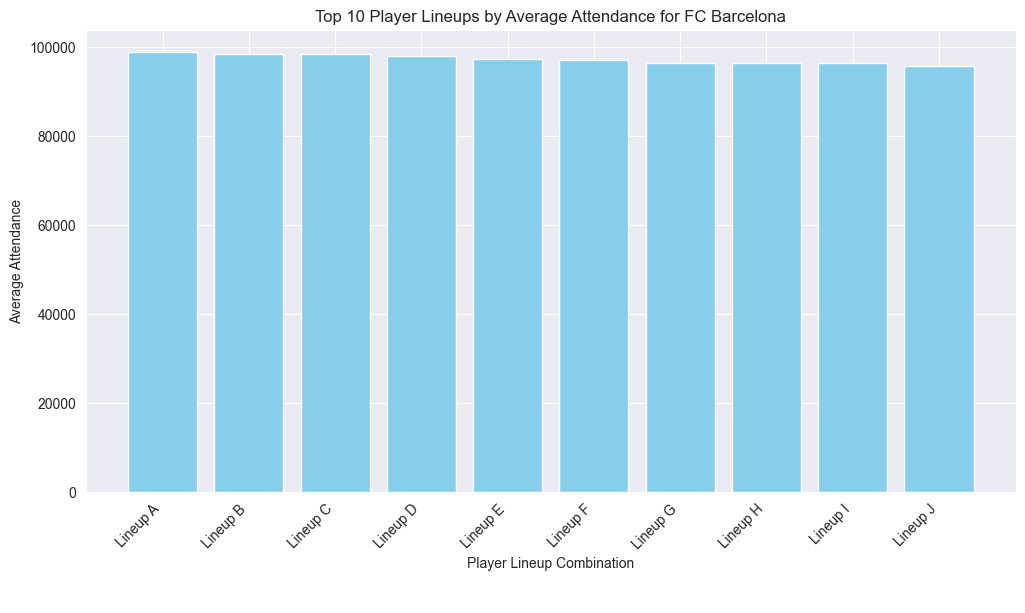

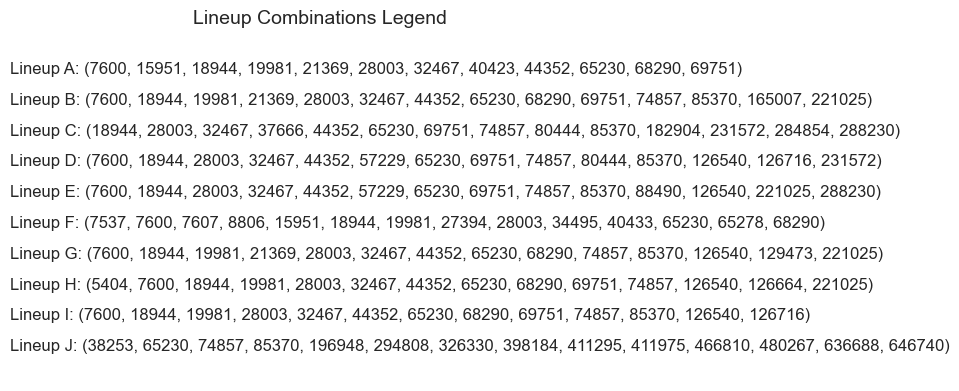

In [129]:
# Hypothesis 1: High-attendance games are associated with specific player lineups.
# Rationale: Popular lineups (i.e., those with star players or effective combinations) might attract more spectators.
# Visualization: A bar plot showing average attendance for different player lineup combinations.


# Drop duplicates to ensure we only have one entry per game_id and lineup combination
unique_lineups = club_data.drop_duplicates(subset=['game_id', 'lineup_combination'])

# Group by lineup combination and calculate average attendance for each unique lineup
lineup_attendance = unique_lineups.groupby('lineup_combination')['attendance'].mean().sort_values(ascending=False).head(10)

# Create labels for each lineup
labels = [f"Lineup {chr(65 + i)}" for i in range(len(lineup_attendance))]
lineup_attendance = lineup_attendance.reset_index()
lineup_attendance['label'] = labels

# Plotting the result
plt.figure(figsize=(12, 6))
plt.bar(lineup_attendance['label'], lineup_attendance['attendance'], color='skyblue')
plt.title('Top 10 Player Lineups by Average Attendance for FC Barcelona')
plt.xlabel('Player Lineup Combination\n\n')
plt.ylabel('Average Attendance')
plt.xticks(rotation=45, ha='right')

# Create a legend block with actual lineup combinations
plt.figure(figsize=(8, 4))
plt.axis('off')  # Turn off the axes

# Add text for the legend
for i, (label, lineup) in enumerate(zip(lineup_attendance['label'], lineup_attendance['lineup_combination'])):
    plt.text(0, 1 - (i * 0.1), f"{label}: {lineup}", fontsize=12, ha='left')

plt.title('Lineup Combinations Legend\n\n', fontsize=14)
plt.show()


### The visual analysis of player lineup combinations and their corresponding average attendance supports the hypothesis that specific lineups significantly impact crowd size for FC Barcelona. Certain lineups consistently draw larger crowds, likely due to factors like the presence of star players, team performance, and opponent strength. While further statistical analysis and consideration of additional variables are necessary, the observed pattern suggests a clear association between player lineup and attendance. Eg: Player 7600 is a player who consistently their in the lineups with highest avg crowd

In [130]:
# Importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

# Load datasets
appearances = appearances
games = games

# Merging data based on game_id for enriched features
data = pd.merge(appearances, games, on="game_id", suffixes=('_player', '_game'))

# Feature Engineering: Selecting relevant columns
data['goal_scored'] = (data['goals'] > 0).astype(int)  # Target variable

features = [
    'player_club_id', 
    'assists', 'minutes_played', 'home_club_goals', 'away_club_goals',
]

# Handling missing values (fill or drop)
data = data[features + ['goal_scored']].dropna()

# Splitting dataset into training and testing sets
X = data[features]
y = data['goal_scored']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [131]:
# Checking class distribution of the target variable
class_distribution = data['goal_scored'].value_counts(normalize=True) * 100
print("Class Distribution:\n", class_distribution)


Class Distribution:
 goal_scored
0    91.412535
1     8.587465
Name: proportion, dtype: float64


In [132]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Check new distribution after SMOTE
print(pd.Series(y_resampled).value_counts(normalize=True) * 100)

from imblearn.under_sampling import RandomUnderSampler

# Apply undersampling to balance the classes
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

# Check new distribution after undersampling
print(pd.Series(y_resampled).value_counts(normalize=True) * 100)


goal_scored
0    50.0
1    50.0
Name: proportion, dtype: float64
goal_scored
0    50.0
1    50.0
Name: proportion, dtype: float64


In [133]:
# Calculate class weights
class_weights = {0: 1, 1: len(y_train[y_train == 0]) / len(y_train[y_train == 1])}

# Train Gradient Boosting with class weight adjustment
gbm = GradientBoostingClassifier(random_state=42)
gbm.fit(X_train, y_train, sample_weight=y_train.map(class_weights))

# Predictions and evaluation
y_pred = gbm.predict(X_test)
y_pred_proba = gbm.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Model Accuracy: {accuracy:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Feature importance
importances = gbm.feature_importances_
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance)


Model Accuracy: 0.62
ROC-AUC Score: 0.72

Feature Importances:
           Feature  Importance
4  away_club_goals    0.334686
3  home_club_goals    0.319804
2   minutes_played    0.281687
1          assists    0.049233
0   player_club_id    0.014589


<Figure size 1000x600 with 0 Axes>

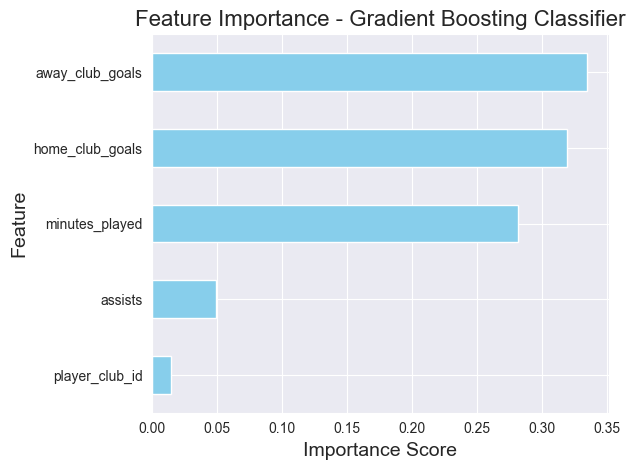

In [134]:
import matplotlib.pyplot as plt

# Plotting feature importance
plt.figure(figsize=(10, 6))
feature_importance.sort_values(by='Importance', ascending=True).plot.barh(x='Feature', y='Importance', legend=False, color='skyblue')
plt.title('Feature Importance - Gradient Boosting Classifier', fontsize=16)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()
